## ДЗ Перцептрон

Реализуйте класс MLP, представляющий многослойный перцептрон. Релизуйте возможность сохранить веса в файлы и загрузить их обратно. Убедитесь в том, чтоб перцептрон обучается.

Реализуйте классы

ActivationF, TanhF(ActivationF)
Unit
Layer
MLP

## ActivationF, TanhF

класс, представляющий функцию активации.

умеет при заданном входном числе (если вам нужно, то каких-то ещё параметрах) вычислить значение функции активации.
умеет при заданном том же входном числе (если вам нужно, то каких-то ещё параметрах) вычислить значение производной функции активации.
математика активации -- та, что указана в имени класса (tanh), можно реализовать ещё несколько.

In [1]:
import math
import abc
import random

In [2]:
class ActivationF(abc.ABC):

    @abc.abstractmethod
    def calc(self, x):
        pass

    @abc.abstractmethod
    def derive(self, x):
        pass

    @staticmethod
    def from_name(name="tanh"):
        if name == "tanh":
            return TanhF()
        if name == 'sigmoid':
            return Sigmoid()

class TanhF(ActivationF):
    def calc(self, x):
        return (math.e**(2*x)-1)/(math.e**(2*x)+1)

    def derive(self, x):
        return 1 - self.calc(x)

class Sigmoid(ActivationF):
    def calc(self, x):
        return 1 / (1 + math.exp(-x))

    def derive(self, x):
        return self.calc(x)*(1-self.calc(x))

## Unit

класс Unit будет представлять нейрон в нейронной сети.
словесно работает нейрон так:

нейрону на вход подаётся набор чисел,
он считает их взвешенную сумму,
применяет к ней функцию активации.
обычно нейрон также умеет, зная, как он вложился в ошибку, обновить свои веса. это -- работа метода backward.

In [3]:
class Unit:
    def __init__(self, input_size, prev_layer: "Layer" = None, activation="tanh"):
        self.activation = ActivationF.from_name(activation)
        self.weights = [random.uniform(-1, 1) for weight_n in range(input_size)]
        self.prev_layer = prev_layer
        self.input_size = input_size
        self.features = [None]
        # your code here

    def features_f(self):
        if self.features[0] == None:
            return self.prev_layer.forward()
        else:
            return self.features


    def forward(self):
        # your code here
        self.sum_f = 0
        self.features = self.features_f()
        for w, f in zip(self.weights, self.features):
            self.sum_f += w*f
        self.sum_f = self.sum_f + self.weights[-1]
        return self.activation.calc(self.sum_f)

    def backward(self, dLoss_dLastLayerOutput, learning_rate=0.01):
        for w, dLoss_dLastLayerOutput_w, x, i in zip(self.weights, dLoss_dLastLayerOutput, self.features, range(len(self.weights))):
            slope = dLoss_dLastLayerOutput_w*self.activation.derive(self.sum_f)*x
            w -= learning_rate*slope
            self.weights[i] = w
        #print(self.weights)

## Layer

Должен иметь возможность создать очередной слой перцептрона. Например,

In [4]:
class Layer:
    def __init__(self, input_size, size, prev_layer = None, activation="tanh"):
        self.activation = activation
        self.units = [Unit(input_size, prev_layer=prev_layer, activation=activation)
                      for unit_n in range(size)]
    
    def forward(self):
        return [unit.forward() for unit in self.units]

    def backward(self, dLoss_dLastLayerOutput):
        return [unit.backward(dLoss_dLastLayerOutput) for unit in self.units]

## MLP

MLP должен

иметь произвольное кол-во слоёв произвольных размерностей
обучатьтся
уметь сохранять/загружать веса
Например,

In [5]:
class MLP:
    def __init__(self, input_size, output_size, sizes, activations):
        self.activations = activations
        self.all_losses = []
        
        layers_sizes = [input_size] + sizes + [output_size]
        
        self.layers = []
        prev_added_layer = None
        for layer_in_size, layer_out_size, act_f in zip(layers_sizes[:-1], layers_sizes[1:], self.activations):
            self.layers.append(Layer(layer_in_size, layer_out_size, prev_layer=prev_added_layer, activation=act_f))
            prev_added_layer = self.layers[-1]
    
    def train_single_entry(self, features, target_mhe):
        # region forward pass
        for unit in self.layers[0].units:
            unit.features = features
        i = 0
        for layer in self.layers:
            i += 1
            curr_layer_output = layer.forward()
        last_layer_output = curr_layer_output
        # endregion forward pass
        def softmax(some_data):
            es_x = [math.e ** x for x in some_data]
            return [e_x / sum(es_x) for e_x in es_x]

        pred = softmax(last_layer_output)
        loss = - sum(class_target * math.log(class_pred)
                     for class_target, class_pred in zip(target_mhe, pred))
        # region backward pass
        dLoss_dLastLayerOutput = [class_pred - class_target
                                  for class_target, class_pred in zip(target_mhe, pred)]
        
        for layer in self.layers:
            layer.backward(dLoss_dLastLayerOutput)
        # your code here
        # endregion backward pass
        self.all_losses.append(loss)
        #print(loss)
        return loss

    def train_model(self, features, target_mhe, n_epoch=100):
        for i in range(n_epoch):
            self.train_single_entry(features, target_mhe)
        
    def save_model(file_name):
        import pickle
        pickle.dump(self, file_name)
    
    def load_model(file_name):
        import pickle
        pickle.load(file_name)

In [6]:
my_MLP = MLP(input_size=4, output_size=4, sizes=[5, 6, 7], activations=['tanh', 'tanh', 'tanh'])

In [7]:
import numpy as np

data_input = np.random.normal(size=4)

data_label = -(data_input)

In [8]:
my_MLP.train_model(data_input, data_label, n_epoch=400)

In [9]:
import matplotlib.pyplot as plt

In [10]:
print(my_MLP.all_losses)

[-5.082526095959903, -5.077526944926255, -5.072578390326823, -5.067685410429399, -5.062852984907234, -5.058086082147501, -5.053389646253056, -5.048768583836551, -5.044227750711995, -5.0397719385938125, -5.035405861916859, -5.031134144892841, -5.026961308918827, -5.022891760452079, -5.018929779462228, -5.015079508566844, -5.0113449429496475, -5.007729921152306, -5.0042381168207415, -5.000873031475626, -4.997637988364123, -4.994536127436487, -4.9915704014768005, -4.9887435734023935, -4.986058214731487, -4.983516705203629, -4.981121233522879, -4.978873799179605, -4.976776215293449, -4.974830112407798, -4.97303694315502, -4.971397987701954, -4.969914359876992, -4.96858701387331, -4.967416751417758, -4.966404229291402, -4.965549967085794, -4.9648543550787, -4.964317662114012, -4.96394004337307, -4.963721547928214, -4.96366212597416, -4.963761635638534, -4.964019849279436, -4.9644364591852135, -4.965011082599429, -4.965743266002335, -4.966632488588832, -4.9676781648918205, -4.968879646508972

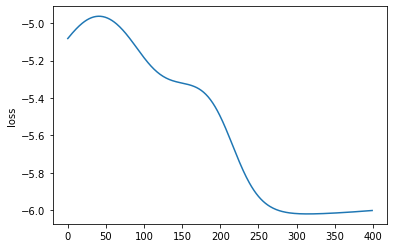

In [11]:
plt.plot(my_MLP.all_losses)
plt.ylabel('loss')
plt.show()